Here I will use the FRIP vs UMI plot to extract out the cell barcodes from the ATAC-seq data so I can run freemuxlet on just the correct barcodes. 

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
sc.set_figure_params(dpi=125)

In [3]:
prefix = '/data/codec/pilot.amo.oct19/atac/'

In [4]:
data = dict()
samples = ['cellranger.outs/well%d/outs/' % i for i in range(1,6)]

In [5]:
data['sc'] = dict()
data['umis'] = dict()
data['frip'] = dict()
for sample in samples:
    data['sc'][sample] = pd.read_csv(prefix + '%ssinglecell.csv' % sample,header=0,index_col=0).iloc[1:,:]
    data['umis'][sample] = np.array(data['sc'][sample]['passed_filters'])
    data['frip'][sample] = np.array(data['sc'][sample]['promoter_region_fragments'])/data['umis'][sample]

/home/ghartoularos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


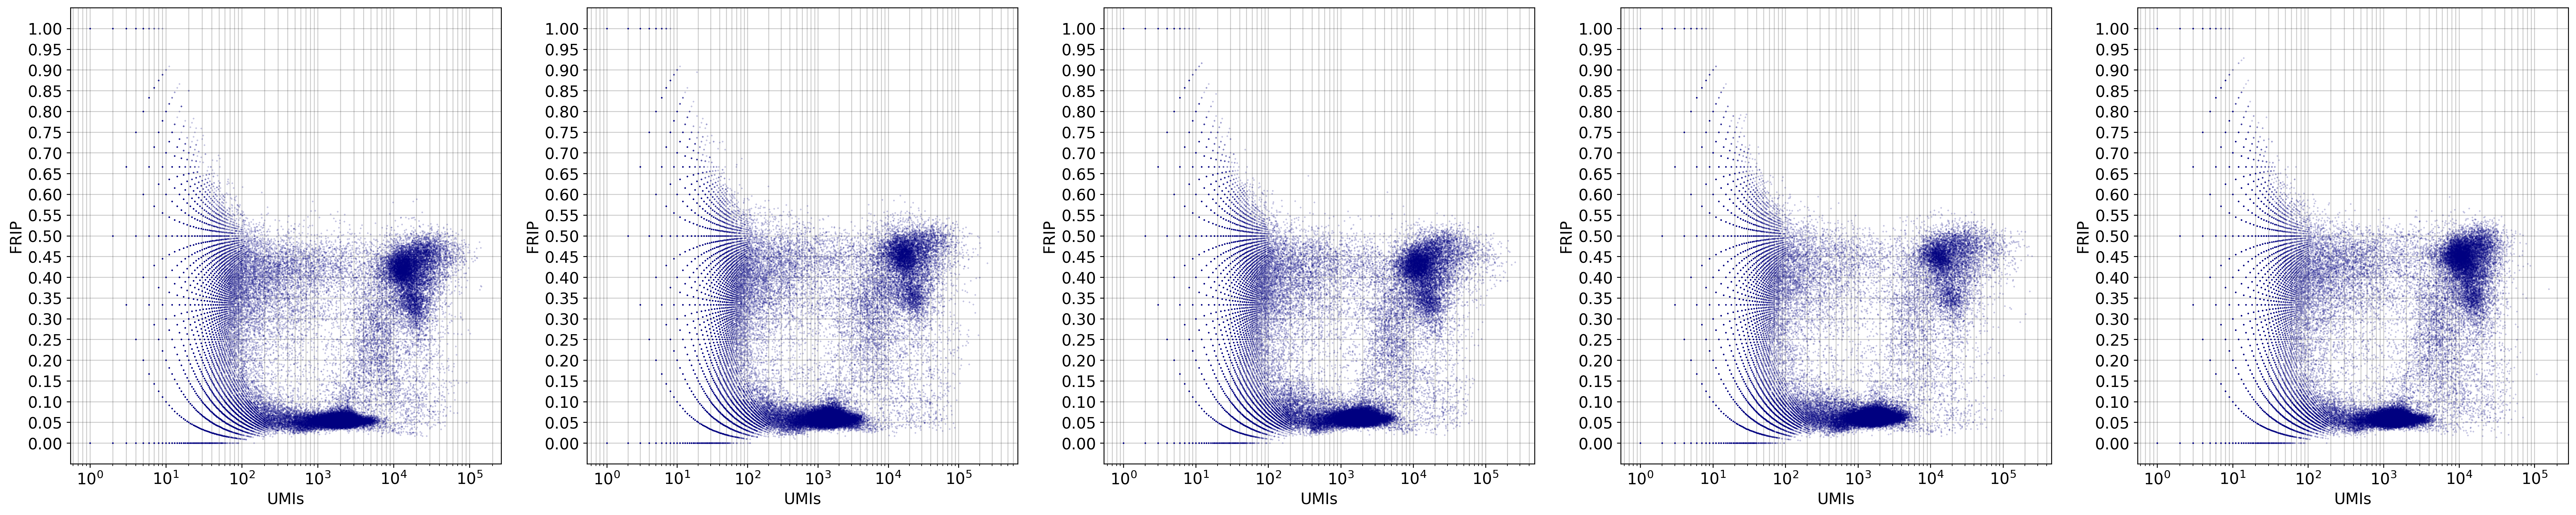

In [9]:
fig, axes = plt.subplots(1,len(samples),figsize=(40,7.5))
for sample, ax in zip(samples,np.ravel(axes)):
    ax.plot(data['umis'][sample], data['frip'][sample], linewidth=0,marker='.',color='navy',markersize=0.25);
    ax.set_xscale('log');
    ax.set_yticks(np.arange(0,1.05,0.05));
    ax.grid(which='both',alpha=0.2,color='k');
    ax.set_ylabel('FRIP');
    ax.set_xlabel('UMIs');

In [6]:
gates_list = list()
gates_list.append(np.array([(5e3, 0.25), (9e4, 0.25), (9e4, 0.55), (5e3, 0.55)]))
gates_list.append(np.array([(5e3, 0.27), (9e4, 0.27), (9e4, 0.55), (5e3, 0.55)]))
gates_list.append(np.array([(4e3, 0.25), (9e4, 0.25), (9e4, 0.55), (4e3, 0.55)]))
gates_list.append(np.array([(5e3, 0.27), (1e5, 0.27), (1e5, 0.55), (5e3, 0.55)]))
gates_list.append(np.array([(3e3, 0.25), (6e4, 0.25), (6e4, 0.55), (3e3, 0.55)]))

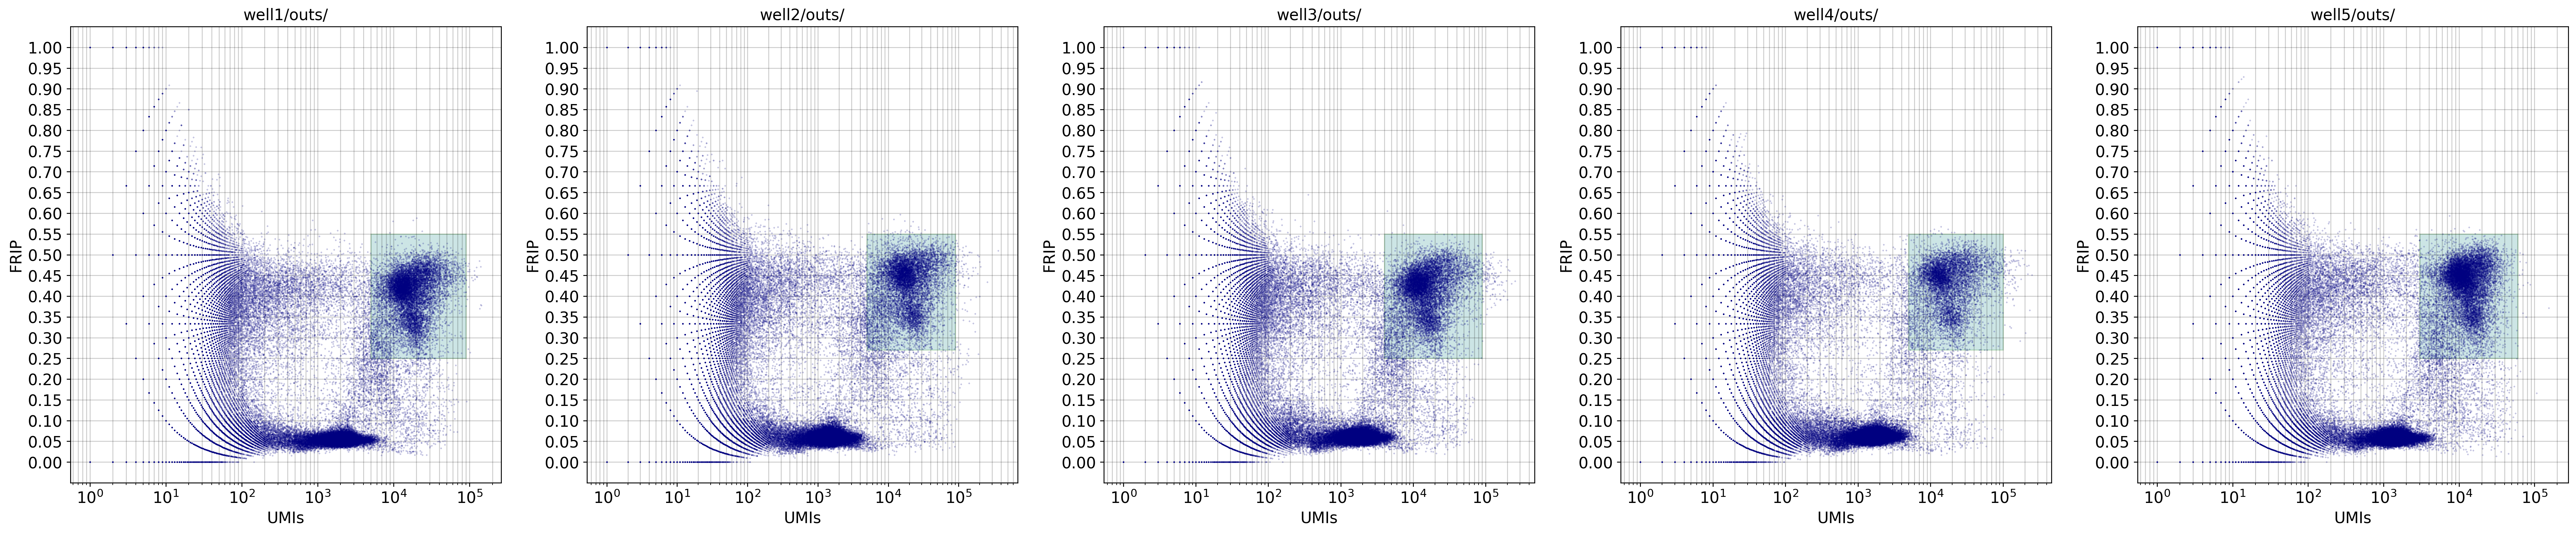

In [17]:
fig, axes = plt.subplots(1,len(samples),figsize=(40,7.5))
for sample, ax, gates in zip(samples,np.ravel(axes), gates_list):
    ax.plot(data['umis'][sample], data['frip'][sample], linewidth=0,marker='.',color='navy',markersize=0.25);
    ax.set_xscale('log');
    ax.set_yticks(np.arange(0,1.05,0.05));
    ax.grid(which='both',alpha=0.2,color='k');
    ax.set_ylabel('FRIP');
    ax.set_xlabel('UMIs');
    ax.set_title(sample)
    gatepatch = patches.Polygon(gates,linewidth=1,edgecolor='green',facecolor='teal',alpha=0.2)
    ax.add_patch(gatepatch);

In [7]:
data['cells'] = dict()
for sample, gates in zip(samples, gates_list):
    pointsmap = map(Point,data['umis'][sample],data['frip'][sample])
    polygon = Polygon(gates)
    data['cells'][sample] = list()
    for i in tqdm(pointsmap,total=len(data['umis'][sample])):
        data['cells'][sample].append(polygon.contains(i))

In [8]:
for sample in samples:
    print(sum(data['cells'][sample]))
    data['cells'][sample] = data['sc'][sample].iloc[data['cells'][sample],:]

11898
9646
11308
7441
13275


In [9]:
sum([len(data['cells'][sample]) for sample in samples])

53568

In [14]:
for sample in samples:
    with open(prefix + 'bcs/%s.bcs.tsv' % sample.split('/')[1], 'w') as file:
        for i in data['cells'][sample].index:
            file.write(i + '\n')